In [2]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.8 MB/s eta 0:00:00a 0:00:010m

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd

import joblib

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb


pd.options.display.max_columns = None
pd.options.display.max_rows = None

import os

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('/Users/yann_vi/Desktop/jedha/Certification_Jedha/Bloc 5 - Getaround Analysis - Deployment/data/get_around_pricing_project.csv' , index_col='Unnamed: 0')

In [8]:
df.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


#Target and features**
##**Target**

###rental_price_per_day
###**Features**

###very well correlated: engine_power, automatic_car, mileage

###well correlated: model_key_, has_getaround_connect, has_gps, car_type, private_parking_available, has_air_conditioning, has_speed_regulator

###slightly correlated: paint_color_, fuel_, winter_tires

In [9]:
features_list = list(df.columns[:-1])
target_variable = 'rental_price_per_day'

X = df.loc[:, features_list]
Y = df.loc[:, target_variable]

##With the use of the train_test_split function, the dataset, 80% for training data and 20% for test data, is seperated.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [11]:
# Automatically detect names of numerical/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

AttributeError: 'Series' object has no attribute 'iteritems'

## Preprocessing

In [7]:
# Preprocessing for features correlation analysis (that's why we don't drop columns in OHE here)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first',handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

Preprocessing X_train...

...Done!
  (0, 0)	-0.13697524611219603
  (0, 1)	0.16120867170881872
  (0, 3)	1.0
  (0, 38)	1.0
  (0, 44)	1.0
  (0, 46)	1.0
  (0, 47)	1.0
  (0, 52)	1.0
  (1, 0)	-0.1601928122265152
  (1, 1)	0.16120867170881872
  (1, 4)	1.0
  (1, 30)	1.0
  (1, 40)	1.0
  (1, 47)	1.0
  (1, 50)	1.0
  (1, 52)	1.0
  (2, 0)	1.1691149778744785
  (2, 1)	0.16120867170881872
  (2, 20)	1.0
  (2, 34)	1.0
  (2, 42)	1.0
  (2, 46)	1.0
  (2, 47)	1.0
  (2, 50)	1.0
  (2, 52)	1.0
  (3, 0)	0.14389943017254048
  (3, 1)	-0.7407589686724106
  (3, 18)	1.0
  (3, 30)	1.0
  (3, 40)	1.0
  (3, 46)	1.0
  (3, 47)	1.0
  (3, 52)	1.0
  (4, 0)	0.510103768430211
  (4, 1)	0.16120867170881872
  (4, 4)	1.0
  (4, 30)	1.0
  (4, 40)	1.0
  (4, 46)	1.0
  (4, 47)	1.0
  (4, 52)	1.0



In [9]:
# Test pipeline
print("Preprocessing X_test...")
print()
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done!")
print(X_test[0:5,:]) # X_test is now a numpy array
print()

Preprocessing X_test...

...Done!
  (0, 0)	0.8970234864247778
  (0, 1)	-1.1273165288357947
  (0, 20)	1.0
  (0, 30)	1.0
  (0, 40)	1.0
  (0, 47)	1.0
  (0, 52)	1.0
  (1, 0)	-1.2114345025888595
  (1, 1)	0.16120867170881872
  (1, 3)	1.0
  (1, 34)	1.0
  (1, 44)	1.0
  (1, 46)	1.0
  (1, 47)	1.0
  (1, 49)	1.0
  (1, 50)	1.0
  (1, 51)	1.0
  (1, 52)	1.0
  (2, 0)	3.080342806648661
  (2, 1)	1.0631763120900481
  (2, 2)	1.0
  (2, 31)	1.0
  (2, 42)	1.0
  (2, 46)	1.0
  (2, 47)	1.0
  (2, 48)	1.0
  (2, 50)	1.0
  (2, 51)	1.0
  (2, 52)	1.0
  (3, 0)	0.8771421688136892
  (3, 1)	-0.9984640087813332
  (3, 4)	1.0
  (3, 30)	1.0
  (3, 41)	1.0
  (3, 52)	1.0
  (4, 0)	0.41068015869873137
  (4, 1)	-0.7407589686724106
  (4, 18)	1.0
  (4, 38)	1.0
  (4, 40)	1.0
  (4, 46)	1.0
  (4, 47)	1.0
  (4, 52)	1.0



## Let's see what we have with a basic linear regression

In [10]:
# create model
model = LinearRegression()

model.fit(X_train, Y_train)

LinearRegression()

In [11]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


In [12]:
print("f1-score on train set : ", r2_score(Y_train, train_pred))
print("f1-score on test set : ", r2_score(Y_test, test_pred))

f1-score on train set :  0.715670343584498
f1-score on test set :  0.6892822444095184


## Let's see with a regularization.

## **LASSO**

In [15]:
# create model
regressor = Lasso(random_state=0)

# Grid of values to be tested
params = {
    'alpha': [0.001, 0.01, 0.1]
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

...Done.
Best hyperparameters :  {'alpha': 0.01}
Best validation accuracy :  0.6985264511025205


## **Random** **Forest**

In [14]:
# Perform grid search
print("Grid search...")
rfr = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [12, 25],
    'min_samples_split': [4],
    'n_estimators': [50, 300]
}

gridsearch = GridSearchCV(rfr, param_grid = params, cv = 3, scoring='r2') # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 25, 'min_samples_split': 4, 'n_estimators': 300}
Best validation accuracy :  0.7417305008296861


In [15]:
# create model
random_forest_regressor = RandomForestRegressor(
    n_estimators= 300,
    max_depth= 25,
    min_samples_split= 4,
    random_state= 3
)

random_forest_regressor.fit(X_train, Y_train)
Y_train_pred = random_forest_regressor.predict(X_train)
Y_test_pred = random_forest_regressor.predict(X_test)

# score full train set
print("f1-score on train set : ", r2_score(Y_train, Y_train_pred))
print("f1-score on test set : ", r2_score(Y_test, Y_test_pred))


f1-score on train set :  0.9499372394564054
f1-score on test set :  0.7707753453125898


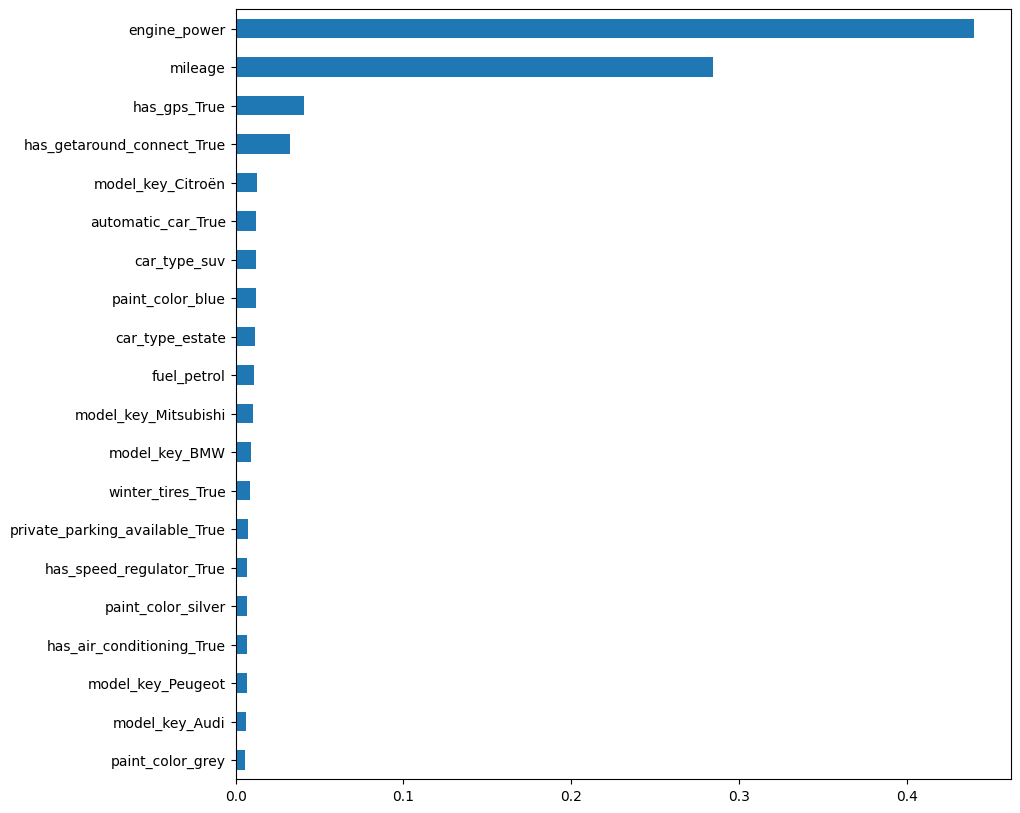

In [25]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
feat_importances = pd.Series(random_forest_regressor.feature_importances_, index=col_names).sort_values(ascending=False)[:20] # limiting to 20 features
plt.figure(figsize=(10,10))
feat_importances.sort_values().plot(kind='barh')
plt.show()

## We can see that only 4 features that have a significant impact to random forest model's prediction (engine_power/mileage / has_gps / has_getaround_connect)

## XGBOOST

In [27]:
# Perform grid search
print("Grid search...")
xgb_regressor = xgb.XGBRegressor()

# Grid of values to be tested

params = {
    'max_depth': [4, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 250],
    'colsample_bytree': [0.9],
    'subsample': [0.8],
}

gridsearch = GridSearchCV(xgb_regressor, param_grid = params, cv = 5, scoring='r2') # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}
Best validation accuracy :  0.7753333295723565


In [28]:
# create model
xgb_regressor = xgb.XGBRegressor(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=250,
    colsample_bytree=0.9,
    subsample=0.8,
    random_state =0
    )

# fit the model with the full train set and predict values for full train an test sets
xgb_regressor.fit(X_train, Y_train)
Y_train_pred = xgb_regressor.predict(X_train)
Y_test_pred = xgb_regressor.predict(X_test)



In [29]:
print("f1-score on train set : ", r2_score(Y_train, Y_train_pred))
print("f1-score on test set : ", r2_score(Y_test, Y_test_pred))

f1-score on train set :  0.8321506915164156
f1-score on test set :  0.7698431991298511


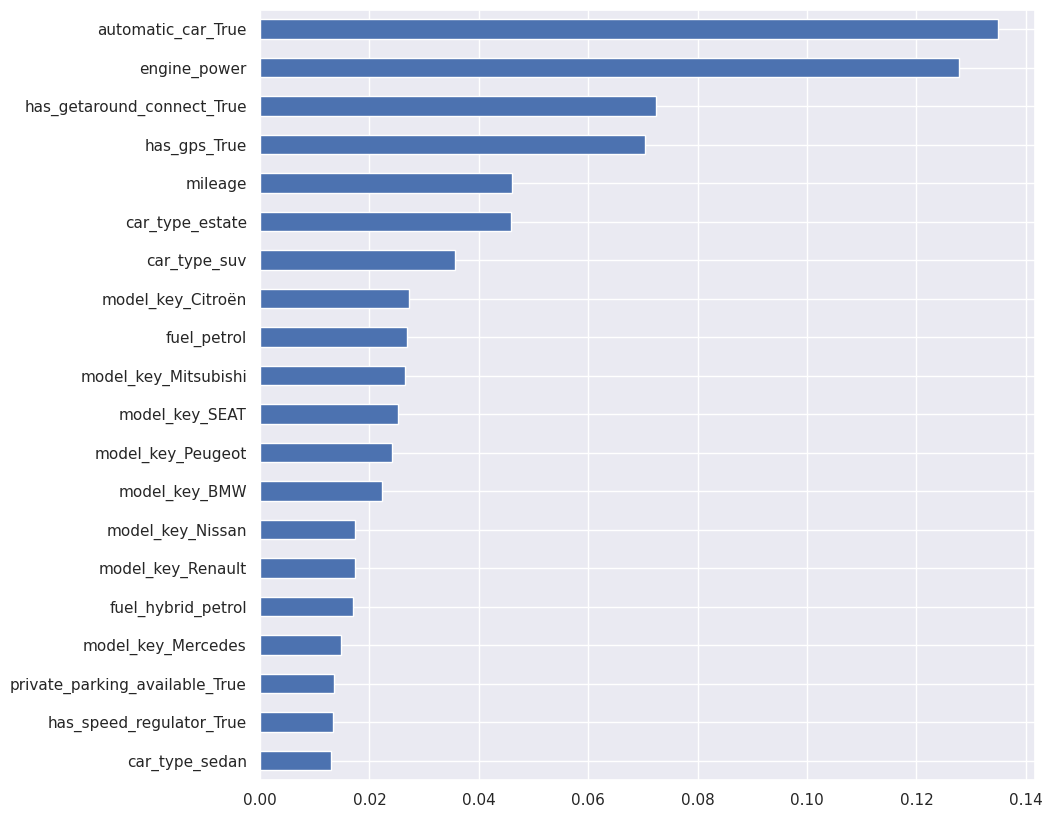

In [31]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
feat_importances = pd.Series(xgb_regressor.feature_importances_, index=col_names).sort_values(ascending=False)[:20] # limiting to 20 features
plt.figure(figsize=(10,10))
feat_importances.sort_values().plot(kind='barh')
plt.show()

## We see with the barhplot that the feature importance with a highest percentage are automatic car/ engine power and has_getaround_connect.